Phan Hong Phuc

# DATA ANALYSIS WITH BID STOCK DATA
---

# Table of Content

1) Introduction
   
2) Importing required libraries
   
3) Data preparation
   
4) Data exploration
   
5) Data modeling
   
6) Conclusion

# Introduction

The goal of the analysis is to provide a tool to assist investors to determine where the favorable trends of stock prices are to buy and sell. The aim of the study will be understand and clean data, perform data visualization and obtain useful information through data mining which can help solve the above problem. In the initial step data assessing is performed in which it was observed that given datasets have mainly two type of issues first is quality issues and second is tidiness issues. The data was then preprocessed, calculating the rate-of-return value series, and converted to time units in the data frame. We fill in the missing price data for Saturdays, Sundays and holidays by the previous day's closing price. To calculate future value of stock shares, we have used time series forecasting model (ARIMA[2,0,1]).

**Data source**

The data to be used in the analysis comes from [Vietstock](https://viettock.vn). I used a my own tool to collect closing prices of stocks from this website, then stored in csv format. More information of my tool can be found [here](https://github.com/P-H-Phuc/Data-Analyst-Portfolio/blob/main/instruments/data_reader.py).

The brief description of stock is as follows:

<table border="0">
 <tr>
    <td><img href=http://bidv.com.vn alt="BID" src="https://finance.vietstock.vn/image/BID" width="201" height="72"/></td>
    <td><b>Joint Stock Commercial Bank for Investment and Development of Vietnam</b>
<br>
Industry: Finance and Insurance/ Credit Intermediation and Related Activities/ Depository Credit Intermediation
<br>
Exchange: HOSE
<br>
Listing date: 01/24/2014
<br>
Outstanding Shares: 4.022.018.040
<br>
Core business
<br>
- Banking: Providing traditional and modern banking services
<br> 
- Insurance: Providing insurance and reinsurance service
<br>
- Securities: Providing securities brokerage, securities custody and investment consultancy services
<br>
- Financial investment: Investing in securities and contributing capital to set up companies…</td>
 </tr>
</table>

# Importing required libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Data preparation

In [ ]:
#Read data from module data_reader.py
#> from pathlib import Path
#> import os; import sys
#> this_dir = os.path.dirname(Path().resolve())
#> sys.path.insert(0, f"{this_dir}\\instruments")
#> import data_reader
#> data = data_reader.get_data('BID', '2017-01-01', '2020-12-31')
#> data.to_csv('raw_data/close_price.csv')

In [2]:
#Read data
df = pd.read_csv('raw_data/close_price.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         1000 non-null   object 
 1   close_price  1000 non-null   float64
dtypes: float64(1), object(1)
memory usage: 15.8+ KB


In [3]:
# set index
index_series = pd.DatetimeIndex(df['date'])
df = df.set_index(index_series).drop('date', axis=1)
#As freq is Day and fillna is yesterday
df = df.asfreq('D')
df.fillna(method='ffill', inplace=True)
#Calculate returns and drop NA
df['returns'] = df['close_price'].diff(1)
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1458 entries, 2017-01-04 to 2020-12-31
Freq: D
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   close_price  1458 non-null   float64
 1   returns      1458 non-null   float64
dtypes: float64(2)
memory usage: 34.2 KB


# Data exploration

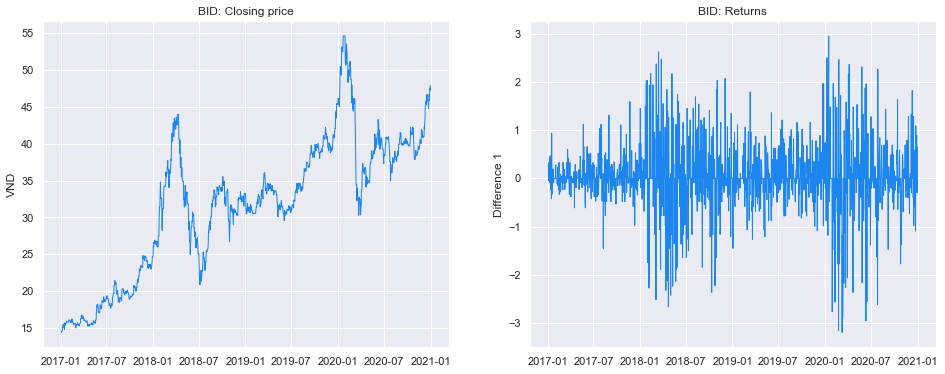

In [4]:
#Visual the stock’s daily closing price and returns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
#For close price
ax1.plot(df.index.values, df['close_price'], color='#1C86EE', linewidth=1)
ax1.set(ylabel='VND'); ax1.set_title('BID: Closing price')
#For returns
ax2.plot(df.index.values, df['returns'], color='#1C86EE', linewidth=1)
ax2.set(ylabel='Difference 1'); ax2.set_title('BID: Returns')
plt.show()

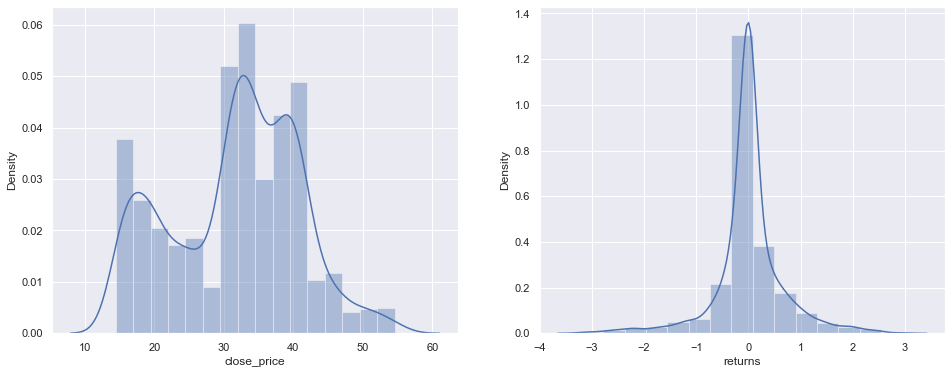

In [5]:
#Distribution of data 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
sns.distplot(df['close_price'], ax=ax1)
sns.distplot(df['returns'], bins=15, ax=ax2)
plt.show()

In [6]:
#Statistics values for this data
df.describe()

,close_price,returns
count,1458.000000,1458.000000
mean,31.653203,0.023114
std,9.265935,0.667079
min,14.430000,-3.190000
25%,24.105000,-0.140000
50%,32.880000,0.000000
75%,38.837500,0.190000
max,54.580000,2.950000


**Augmented Dickey-Fuller (ADF test)**

The Dickey-Fuller test can be used to determine whether or not a series has a unit root, and thus whether or not the series is stationary. This test’s null and alternate hypotheses are:

- Null Hypothesis: The series has a unit root (value of a = 1) 
- Alternate Hypothesis: The series has no unit root.

If the null hypothesis is not rejected, the series is said to be non-stationary. The series can be linear or difference stationary as a result of this. 

In [7]:
#Timeseries
timeseries = df['returns']
#ADF test
adf_price = adfuller(timeseries, autolag='AIC')
print("-- Results of Dickey Fuller Test for BID's Returns --")
print('1. Test Statistics:', adf_price[0])
print('2. p-value:', adf_price[1])
print('3. No. of lags used:', adf_price[2])
print('4. Number of observations used:', adf_price[3])
for key, values in adf_price[4].items():
    print('\tCritical value (%s):'%key, values)

-- Results of Dickey Fuller Test for BID's Returns --
1. Test Statistics: -26.56773124542152
2. p-value: 0.0
3. No. of lags used: 1
4. Number of observations used: 1456
	Critical value (1%): -3.43484922137066
	Critical value (5%): -2.8635271063560412
	Critical value (10%): -2.5678279184465946


The null hypothesis can be excluded because the p-value is less than 0.05. In addition, the test statistic does not exceed the significant values. As a result, the data is linear.

# Data modeling

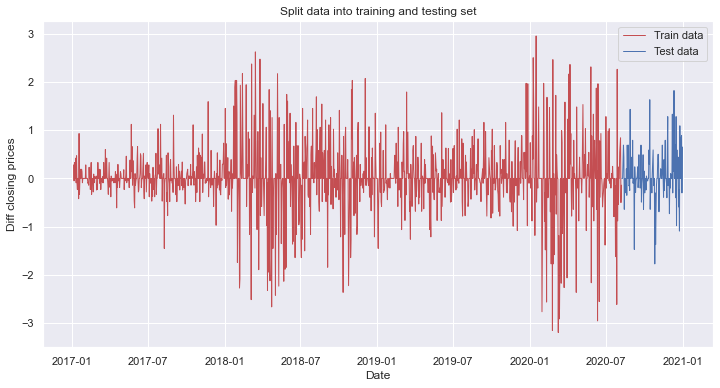

In [8]:
#Divide it into train and test sets prob is 0.9
prob = 0.9
train_ts, test_ts = timeseries[0:int(len(timeseries)*prob)], timeseries[int(len(timeseries)*prob):]
#Visual the data
fig, ax = plt.subplots(figsize=(12,6))
ax.plot_date(train_ts.index.values, train_ts.values, 
             fmt='-r', linewidth=1, label='Train data')
ax.plot_date(test_ts.index.values, test_ts.values, 
             fmt='-b', linewidth=1, label='Test data')
ax.set(xlabel='Date', ylabel='Diff closing prices')
ax.set_title('Split data into training and testing set')
ax.legend()
plt.show()

### auto_arima function

Automatically discover the optimal order for an ARIMA model

In [9]:
auto_model = auto_arima(train_ts, start_p = 1, start_q = 1,
                        max_p = 5, max_q = 5, m = 12, seasonal = False,
                        d = None, trace = False, error_action ='ignore',
                        suppress_warnings = True,
                        stepwise = True)
print('The best ARIMA model: ARIMA', auto_model.order, sep='')

The best ARIMA model: ARIMA(2, 0, 1)


**Test diagnostics**

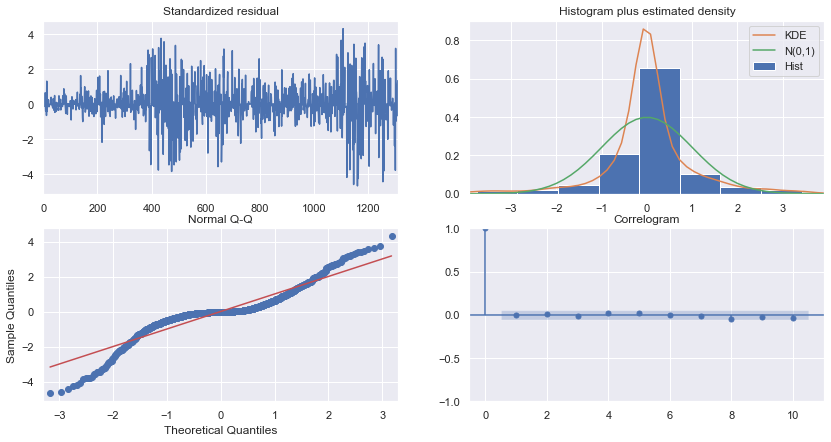

In [10]:
auto_model.plot_diagnostics(figsize=(14,7))
plt.show()

### Build model

In [11]:
#Build model use the order from above auto_model
model = ARIMA(train_ts, order=auto_model.order)
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 1312
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -1353.824
Date:                Sun, 19 Dec 2021   AIC                           2717.647
Time:                        19:51:39   BIC                           2743.544
Sample:                    01-04-2017   HQIC                          2727.359
                         - 08-07-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0178      0.025      0.718      0.473      -0.031       0.066
ar.L1          0.8609      0.060     14.294      0.000       0.743       0.979
ar.L2          0.0722      0.021      3.479      0.0

### Forecast out-of-sample

Forecasting stock prices on the test dataset with a 90% confidence level:

In [12]:
# Multi-step out-of-sample forecast, Confidence 90%
start_index = len(train_ts)
end_index = len(train_ts) + len(test_ts) - 1 
df_forecast = fitted.get_prediction(start=start_index, end=end_index, dynamic=False).summary_frame(alpha=0.9)

In [13]:
# Invert differenced value to actual value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
# Forecast mean, ci lower, ci upper
mean_forecast = [df['close_price'].iloc[start_index - 1]]
ci_lower = [df['close_price'].iloc[start_index - 1]]
ci_upper = [df['close_price'].iloc[start_index - 1]]

for mean in df_forecast['mean']:
    x = inverse_difference(mean_forecast, mean)
    mean_forecast.append(x)
forcast_series = pd.Series(mean_forecast[1:], index=test_ts.index)

for low in df_forecast['mean_ci_lower']:
    y = inverse_difference(ci_lower, low)
    ci_lower.append(y)
lower_series = pd.Series(ci_lower[1:], index=test_ts.index)

for up in df_forecast['mean_ci_upper']:
    z = inverse_difference(ci_upper, up)
    ci_upper.append(z)
upper_series = pd.Series(ci_upper[1:], index=test_ts.index)

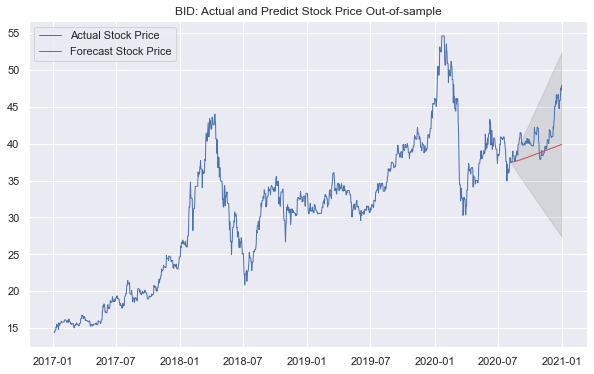

In [14]:
# Visual
fig, ax = plt.subplots(figsize=(10,6))
ax.plot_date(df['close_price'].index.values, df['close_price'].values, 
             fmt='-b', label='Actual Stock Price', linewidth=1)
ax.plot_date(forcast_series.index.values, forcast_series.values,
             fmt='-r', label='Forecast Stock Price', linewidth=1)
plt.fill_between(lower_series.index.values, lower_series.values, 
                     upper_series.values, color='k', alpha=.1)
ax.set(xlabel='', ylabel='')
ax.set_title('BID: Actual and Predict Stock Price Out-of-sample')
ax.legend(loc='upper left')
plt.show()

In [15]:
#Calculate MAPE, MSE for model
y_true = df['close_price'].iloc[start_index:]
y_pred = forcast_series
mape = mean_absolute_percentage_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
print(f"- Mean absolute percentage error: {round(mape*100, 3)}%")
print(f'- Mean squared error: {round(mse, 3)}')

- Mean absolute percentage error: 5.406%
- Mean squared error: 9.006


# Conclusion

The forecast results show that the arima model has roughly predicted the trend of stock prices in the last months of 2020. We see that the actual value is within the 90% confidence interval. This gives the smart investor a measure of the potential for loss or gain on his investment.